# Digit Recognizer

In this notebook we attempt to classify digits using a convolutive neural network. Data taken from the digit-recognizer dataset on Kaggle.

In [16]:
'''Imports'''
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout
import seaborn as sns
%matplotlib inline

np.random.seed(8)
sns.set(style='white', context='notebook', palette='deep')

'''Constants'''
img_rows = 28
img_cols = 28
num_classes = 10

# Model parameters
n_filters = 12       # What does this do?
kernel_size = 3      # What does this do?
activ = 'relu'       
final_activ = 'softmax'
inp_shape = (img_rows, img_cols, 1)
n_neurons = 100
drop_prob = 0

# Compiler parameters
loss = keras.losses.categorical_crossentropy
optimizer = 'adam'
metrics = ['accuracy']

# Fitting parameters
batch_size = 521
epochs = 11
validation_split = 0.2


'''Load dataset'''
data_directory = 'C:\\Users\\David Montgomery\\.kaggle\\competitions\\digit-recognizer\\'

train_directory = data_directory + "train.csv"
test_directory = data_directory + "test.csv"

train_df = pd.read_csv(train_directory)
test_df = pd.read_csv(test_directory)

train_df = train_df.dropna(axis=0)

In [19]:
# View the loaded data
train_df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,5731.000000,5731.0,5731.0,5731.0,5731.0,5731.0,5731.0,5731.0,5731.0,5731.0,...,5731.000000,5731.000000,5731.000000,5731.0,5731.0,5731.0,5731.0,5731.0,5731.0,5731.0
mean,4.437969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.153551,0.156517,0.029663,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.878054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.348662,5.800864,1.757306,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,253.000000,130.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


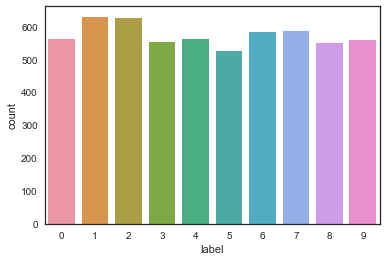

In [24]:
'''Data preparation'''
data = train_df.as_matrix()

y = data[:,0]
y_out = keras.utils.to_categorical(y, num_classes)

X = data[:,1:]
num_of_images = y.shape[0]
X_out = X.reshape(num_of_images, img_rows, img_cols, 1)
X_out = X_out/255

# Have a look at balance of training data
Y_train = train_df["label"]
type(Y_train)
g = sns.countplot(Y_train)

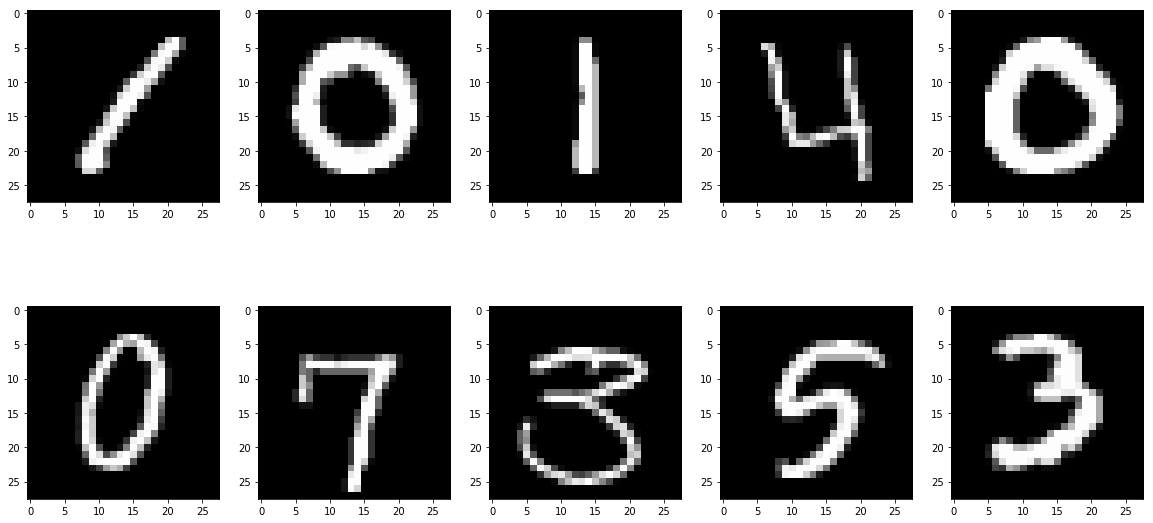

In [5]:
'''View first 10 digits'''
plt.figure(figsize=(20,10))
for i in range(10):
    row = X[i,:]
    row = np.reshape(row, [img_rows, img_cols])
    plt.subplot(2, 5, i+1)
    plt.imshow(row, cmap='gray')

In [6]:
'''Create model'''
digit_model = Sequential()
digit_model.add(Conv2D(n_filters,
                      kernel_size=kernel_size,
                      activation=activ,
                      input_shape=inp_shape))
digit_model.add(Dropout(drop_prob))
digit_model.add(Conv2D(n_filters,
                      kernel_size=kernel_size,
                      activation=activ))
digit_model.add(Dropout(drop_prob))
digit_model.add(Conv2D(n_filters,
                      kernel_size=kernel_size,
                      activation=activ))
digit_model.add(Dropout(drop_prob))
digit_model.add(Flatten())
digit_model.add(Dense(n_neurons,
                     activation=activ))
digit_model.add(Dense(num_classes,
                     activation=final_activ))

'''Compile model'''
digit_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [7]:
'''Model fitting'''
digit_model.fit(x=X_out, y=y_out, batch_size=batch_size, epochs=epochs,
               validation_split=validation_split)

Train on 4584 samples, validate on 1147 samples
Epoch 1/11
4584/4584 [==============================] - 7s 1ms/step - loss: 1.7660 - acc: 0.5816 - val_loss: 0.9401 - val_acc: 0.7786
Epoch 2/11
4584/4584 [==============================] - 6s 1ms/step - loss: 0.6309 - acc: 0.8248 - val_loss: 0.5133 - val_acc: 0.8466
Epoch 3/11
4584/4584 [==============================] - 6s 1ms/step - loss: 0.4233 - acc: 0.8761 - val_loss: 0.4085 - val_acc: 0.8710
Epoch 4/11
4584/4584 [==============================] - 6s 1ms/step - loss: 0.3303 - acc: 0.9034 - val_loss: 0.3309 - val_acc: 0.8945
Epoch 5/11
4584/4584 [==============================] - 6s 1ms/step - loss: 0.2661 - acc: 0.9223 - val_loss: 0.3076 - val_acc: 0.8971
Epoch 6/11
4584/4584 [==============================] - 6s 1ms/step - loss: 0.2300 - acc: 0.9356 - val_loss: 0.2835 - val_acc: 0.9111
Epoch 7/11
4584/4584 [==============================] - 7s 1ms/step - loss: 0.1933 - acc: 0.9472 - val_loss: 0.2542 - val_acc: 0.9189
Epoch 8/11
458

## Test set
Now that we have a somewhat decent model we continue to predict on the test set


In [10]:
'''Data preparation'''
data = test_df.as_matrix()
X = data
num_of_images = X.shape[0]
X_out = X.reshape(num_of_images, img_rows, img_cols, 1)
X_out = X_out/255

'''Generate predictions'''
y_hat = digit_model.predict(X_out)

# Select inde with maximum probability
results = np.argmax(y_hat, axis=1)
results = pd.Series(results, name="Label")

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [11]:
# Write to csv
submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv("cnn_mnist_datagen.csv", index=False)